# Summation modeling using multiple convolved traces:
(written by Amanda Ray for the publication "Nonlinear integration of sensory inputs and behavioral state by a single neuron in C. elegans" doi: https://doi.org/10.1101/2025.04.05.647390) 

Written: 04.07.25, last updated: 10.08.25


This code will walk through summing the convolved traces of multiple neurons to model AIB. Here we will use WT AVA, AIA, and AWC. I will also detail how to apply to ignored and absent models. 


** Please note that I am an amateur at coding. I'm sure there are more efficient ways to code things, so please feel free to rewrite code more proficiently for your own usage! :) **

In [98]:
## Imports ##

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy
import math
import statistics
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd

In [99]:
## Importing Dictionary Datasets ##

# Worm numbers
WT_worm_num = 15
WT_AWC_worm_num = 20
nmrHis_worm_num = 20
insHis_worm_num = 12
strHis_worm_num = 14

# All datasets include odor, red light, and odor + red light (nicknamed 'both') experiments for each neuron.
# allow_pickle=True).item() needed for items with multiple elements (ie 2D arrays)

# AVA-AIB-AIA traces for WT worms - 15 worms #
WT_dict = np.load('WT AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(WT_dict)

# AWC traces for WT worms - 20 worms #
WT_AWC_dict = np.load('WT AWC.npy', allow_pickle=True).item()
#print(WT_AWC_dict)

# AVA-AIB-AIA traces for nmr-1::HisCl (motor-silenced) worms - 20 worms #
nmrHis_dict = np.load('nmr-1_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(nmrHis_dict)

# AVA-AIB-AIA traces for str-2::HisCl (AWC-silenced) worms - 14 worms #
strHis_dict = np.load('str-2_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(strHis_dict)

# AVA-AIB-AIA traces for ins-1s::HisCl (AIA-silenced) worms - 12 worms #
insHis_dict = np.load('ins-1s_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(insHis_dict)

print("Imported data successfully!")

#--------------#
# Also import relevant single neuron convolution parameters obtained from 
# 'Modeling Neuron Data - Single Neuron Convolution.ipynb' notebook
# Here, we will just use the median WT AVA-Only alpha values for all the kernels.

WT_AVA_only_params = np.load('WT AVA Only Param Medians.npy', allow_pickle=True).item()
print(WT_AVA_only_params)

Imported data successfully!
{'Alpha1 Odor': 0.015819636374971073, 'Alpha1 Red': 0.015922383969636245, 'Alpha1 Both': 0.015891533926751463, 'Alpha2 Odor': 0.06397583113215952, 'Alpha2 Red': 0.06424806825696902, 'Alpha2 Both': 0.06415579992647433}


In [100]:
# Find and return data arrays of interest for each worm, type of trace (raw, background corrected, or normalized), 
# and experiment (odor, red light, odor+red [named "both"]). 

def FindNeurons(dictionary, data_type, neuron_name, exp):
    
    array = []
    
    for key, value in dictionary.items(): # this loops through worms and types of traces
        for key2, value2 in value.items(): # for each worm, loops through the types of data to get arrays
            if data_type in key and neuron_name in key2 and exp in key2:
                array.append(value2)
                
    if not array: # Check if correct array exists, otherwise will be empty
        print("Error! Does not exist! Make sure you are in correct dictionary and using correct keywords!")
    else:       
        return array
    
# WT #
# Pull out full set of experiments for AIB, AVA, AIA, AND AWC.
# We will use normalized data.

WT_AIB_odor = FindNeurons(WT_dict, "Norm", "AIB", "Odor")
WT_AIB_red = FindNeurons(WT_dict, "Norm", "AIB", "Red")
WT_AIB_both = FindNeurons(WT_dict, "Norm", "AIB", "Both")

WT_AVA_odor = FindNeurons(WT_dict, "Norm", "AVA", "Odor")
WT_AVA_red = FindNeurons(WT_dict, "Norm", "AVA", "Red")
WT_AVA_both = FindNeurons(WT_dict, "Norm", "AVA", "Both")

WT_AIA_odor = FindNeurons(WT_dict, "Norm", "AIA", "Odor")
WT_AIA_red = FindNeurons(WT_dict, "Norm", "AIA", "Red")
WT_AIA_both = FindNeurons(WT_dict, "Norm", "AIA", "Both")

WT_AWC_odor = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Odor")
WT_AWC_red = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Red")
WT_AWC_both = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Both")

# NOTE: Since AWC recordings were performed in a separate worm and do not correlate with the same worm recordings
# with AVA-AIB-AIA worms, we will actually use the averaged traces of AWC for each experiment as a representative
# of AWC activity for modeling, since AWC responses to odor pulses are so consistent across trials.
# Then we're going to duplicate it to make looping through easier for modeling. 
# This is useful mostly for being able to switch the order of AWC during ignoring and silencing exps.
# I duplicated it by 20 because that's the largest number of worms I have in the datasets (motor-silenced=20)
WT_AWC_odor_avg = np.mean(WT_AWC_odor, axis=0)
WT_AWC_red_avg = np.mean(WT_AWC_red, axis=0)
WT_AWC_both_avg = np.mean(WT_AWC_both, axis=0)

WT_AWC_odor_avg = [WT_AWC_odor_avg]*20 
WT_AWC_red_avg = [WT_AWC_red_avg]*20
WT_AWC_both_avg = [WT_AWC_both_avg]*20


# Silencing Data #

# Motor-silenced (nmr-1::HisCl):
# For modeling, we only need the odor+red light (both) exps. Also note we only need to pull out
# AIB and AIA data since AVA data is silenced, and we use WT_AWC_both_avg data for AWC.
nmrHis_AIB_both = FindNeurons(nmrHis_dict, "Norm", "AIB", "Both")

nmrHis_AIA_both = FindNeurons(nmrHis_dict, "Norm", "AIA", "Both")


# AWC-silenced:
# For modeling, we only need the red-light experiments to activate AIA since AWC is silenced. 
strHis_AIB_red = FindNeurons(strHis_dict, "Norm", "AIB", "Red")

strHis_AVA_red = FindNeurons(strHis_dict, "Norm", "AVA", "Red")

strHis_AIA_red = FindNeurons(strHis_dict, "Norm", "AIA", "Red")


# AIA-silenced:
# For modeling, we only need the odor experiments to activate AWC since AIA is silenced. Also note
# we only need to pull out AIB and AVA data since AIA is silenced, and we use WT_AWC_odor_avg data for AWC.
insHis_AIB_odor = FindNeurons(insHis_dict, "Norm", "AIB", "Odor")

insHis_AVA_odor = FindNeurons(insHis_dict, "Norm", "AVA", "Odor")

print('Done')


Done


In [101]:
## - Model AIB data by summing multiple neuron convolutions - ##

# Method uses downhill simplex method (Nelder-Mead) via scipy optimize to find the smallest residual between 
# model and real AIB. Need to seed the function first with some parameters (params) to help find optimum solution. 
# Due to similarity in alpha 1 & 2 values in kernels (see 'Modeling Neuron Data - Single Neuron Convolution.ipynb'
# code for details), we use the same fixed values, which are the median values from AVA-only modeling. 
# Thus, we are just allowing amplitudes for each neuron to be fitted, and will save those. 

# This function sums up to 3 neurons, if we are ignoring/silencing a neuron, leave neuron3 as 'BLANK'

def Convolution_Summation(AIB, neuron1, neuron2, neuron3, alpha1_input, alpha2_input, params, worm_num):
    time = 250 # kernel time window, we found 250 frames to be a good time period
    t = np.arange(0, time)
    
    models = [] 
    neuron1_amp = []
    neuron2_amp = []
    neuron3_amp = []
    res = [] 
    
    def Model(neuron1, neuron2, neuron3, alpha1_input, alpha2_input, params):
        kernel_min = (np.exp(-alpha1_input*t) - np.exp(-alpha2_input*t))
        
        amp1 = params[0]
        amp2 = params[1]
        kernel1 = amp1 * kernel_min
        kernel2 = amp2 * kernel_min
        
        if neuron3 == 'BLANK':
            model = np.convolve(neuron1,kernel1, 'valid') + np.convolve(neuron2,kernel2, 'valid')
        else:
            amp3 = params[2]
            kernel3 = amp3 * kernel_min
            model = np.convolve(neuron1,kernel1, 'valid') + np.convolve(neuron2,kernel2, 'valid') + np.convolve(neuron3,kernel3, 'valid')
        
        # 'valid' method produces convolution where the beginning of the original trace is lost.
        # Loss is calculated by time window used (250) minus 1, so that resulting model is 249 frames less than 
        # original. This becomes important for plotting later to properly align model with original traces.
        
        return model
        
    for i in range(worm_num):
        #print('Worm #: ', i) # can uncomment to show progress
        def Res(params):
            if neuron3 == 'BLANK':
                model_AIB = Model(neuron1[i], neuron2[i], 'BLANK', alpha1_input, alpha2_input, params)
            else:
                model_AIB = Model(neuron1[i], neuron2[i], neuron3[i], alpha1_input, alpha2_input, params)
            
            loss = time - 1 # this is from convolution loss (see comment above)
            # to align real AIB with model, we have to cut off the loss in the beginning (AIB[i][loss:])
            
            # Residual:
            # take difference of real vs model AIB, square it, divide it by number of frames, then take square root
            Residual = np.sqrt(np.sum(np.subtract(AIB[i][loss:],model_AIB)**2) / len(model_AIB))
            return Residual

        optimize = minimize(Res, params, method='Nelder-Mead') # optimizing for smallest solution (residual)
        res.append(optimize['fun']) # want to save resulting residual
        parameters_new = optimize['x'] # final new parameters based on optimization
        neuron1_amp.append(parameters_new[0])
        neuron2_amp.append(parameters_new[1])
        if neuron3 == 'BLANK':
            new_model = Model(neuron1[i], neuron2[i], 'BLANK', alpha1_input, alpha2_input, parameters_new)
        else:
            neuron3_amp.append(parameters_new[2])
            new_model = Model(neuron1[i], neuron2[i], neuron3[i], alpha1_input, alpha2_input, parameters_new)
        models.append(new_model) # save resulting model

    return res, models, neuron1_amp, neuron2_amp, neuron3_amp

p_sum = [0.09, 0.09, 0.09] 
# Parameters used for seeding initial optimization. Order corresponds to order of neurons
# These were determined through a series of tests. Seeded values too far off can sometimes result in the 
# model getting stuck in local minima. Feel free to try others. AIA works well with more negative numbers.
# I use these same seeding parameters for all summation models (see below) for consistency.

# I will only show WT modeling here, and I'm using odor+red light (both) experiments for full AWC and AIA
# activation for modeling. Other versions of models see below.

WT_worm_num = 15

## WT - Sum all 3 AVA+AWC+AIA ##
WT_sum = Convolution_Summation(WT_AIB_both, WT_AVA_both, WT_AWC_both_avg, WT_AIA_both, 
                               WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   p_sum, WT_worm_num)
WT_sum_res = WT_sum[0]
WT_sum_models = WT_sum[1]
WT_sum_AVA_amp = WT_sum[2]
WT_sum_AWC_amp = WT_sum[3]
WT_sum_AIA_amp = WT_sum[4]

# - Save Residuals and Amplitudes For Comparison Later - #
# We especially need to save the AVA amplitudes because we will use this in the derivative reversal-dependent model.
# We actually use the same (full) WT AVA amp for all ignored derivative modeling too (they are very similar)
# We can save the other amps for comparison with rest of models or statistics later.
np.save('WT Sum Residual.npy', WT_sum_res)

WT_amps = {'AVA Amp':WT_sum_AVA_amp, 'AWC Amp':WT_sum_AWC_amp, 'AIA Amp':WT_sum_AIA_amp}                                                
np.save('WT Sum Amps.npy', WT_amps)

print('WT: done')


/var/folders/h2/nr_g6r3s37v0y4h9l4yjz0bw0000gn/T/ipykernel_35136/1951950165.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if neuron3 == 'BLANK':


WT: done


In [102]:
## WT - Ignore ##
# For ignore models, want to use odor+red light (both) exps for maximum neuron activity.
# Also use the same alpha1/2 parameters for all kernels due to similarity

# ignore AVA: AWC + AIA
WT_iAVA_sum = Convolution_Summation(WT_AIB_both, WT_AWC_both_avg, WT_AIA_both, 'BLANK',
                                   WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   p_sum, WT_worm_num)
WT_iAVA_sum_res = WT_iAVA_sum[0]
WT_iAVA_sum_models = WT_iAVA_sum[1]
WT_iAVA_sum_AWC_amp = WT_iAVA_sum[2]
WT_iAVA_sum_AIA_amp = WT_iAVA_sum[3]

# ignore AWC: AVA + AIA
WT_iAWC_sum = Convolution_Summation(WT_AIB_both, WT_AVA_both, WT_AIA_both, 'BLANK',
                                   WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   p_sum, WT_worm_num)
WT_iAWC_sum_res = WT_iAWC_sum[0]
WT_iAWC_sum_models = WT_iAWC_sum[1]
WT_iAWC_sum_AVA_amp = WT_iAWC_sum[2]
WT_iAWC_sum_AIA_amp = WT_iAWC_sum[3]

# ignore AIA: AVA + AWC
WT_iAIA_sum = Convolution_Summation(WT_AIB_both, WT_AVA_both, WT_AWC_both_avg, 'BLANK',
                                   WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   p_sum, WT_worm_num)
WT_iAIA_sum_res = WT_iAIA_sum[0]
WT_iAIA_sum_models = WT_iAIA_sum[1]
WT_iAIA_sum_AVA_amp = WT_iAIA_sum[2]
WT_iAIA_sum_AWC_amp = WT_iAIA_sum[3]

# - Save Residuals and Amplitudes For Comparison Later - #
# We actually use the same (full) WT AVA amp above for all ignored derivative modeling (they are very similar).
# If you want to save the ignored AVA amplitudes, for their corresponding ignored derivative models, go ahead. 
# We can save the other amps for comparison with rest of models or statistics later.

ignored_res = {'iAVA':WT_iAVA_sum_res, 'iAWC': WT_iAWC_sum_res, 'iAIA': WT_iAIA_sum_res}  
np.save('Ignored Sum Residuals.npy', ignored_res)

ignored_amps = {'iAVA-AWC Amp':WT_iAVA_sum_AWC_amp, 'iAVA-AIA Amp':WT_iAVA_sum_AIA_amp, 
                'iAWC-AVA Amp':WT_iAWC_sum_AVA_amp, 'iAWC-AIA Amp':WT_iAWC_sum_AIA_amp, 
               'iAIA-AVA Amp':WT_iAIA_sum_AVA_amp, 'iAIA-AWC Amp':WT_iAIA_sum_AWC_amp}                                                
np.save('Ignored Sum Amps.npy', ignored_amps)

print('WT (ignore): done')


WT (ignore): done


In [103]:
## Silencing ##

# -*- Make sure respective data is imported -*- #

# Motor silenced - use odor+red light exps to activate AWC and AIA. #
# Note we use the same WT AWC activity since AWC activity will be unaffected. 
# Also use the same alpha1/2 parameters because the kinetic properties of AIB should be unchanged
noAVA_sum = Convolution_Summation(nmrHis_AIB_both, WT_AWC_both_avg, nmrHis_AIA_both, 'BLANK',
                                   WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   p_sum, nmrHis_worm_num)
noAVA_sum_res = noAVA_sum[0]
noAVA_sum_models = noAVA_sum[1]
noAVA_sum_AWC_amp = noAVA_sum[2]
noAVA_sum_AIA_amp = noAVA_sum[3]

# AWC silenced/inactive - use red light exps to only activate AIA. #
# Note we use the AVA-only both params for alpha1/2, since it is so similar to other exps. 
# Feel free to change to Red exp to be more specific
noAWC_sum = Convolution_Summation(strHis_AIB_red, strHis_AVA_red, strHis_AIA_red, 'BLANK',
                                   WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   p_sum, strHis_worm_num)
noAWC_sum_res = noAWC_sum[0]
noAWC_sum_models = noAWC_sum[1]
noAWC_sum_AVA_amp = noAWC_sum[2]
noAWC_sum_AIA_amp = noAWC_sum[3]

# AIA silenced - use odor exps to activate AWC. #
# Note that we use the same WT AVA-only alpha parameters because they are identical to AIA-silenced AVA model.
# If you want, you can apply the single-neuron model in ins-1s_hiscl dataset for an AVA-only model to
# obtain new AVA-only alpha parameters to be more specific.
# Note that we use the same WT AWC activity. 
noAIA_sum = Convolution_Summation(insHis_AIB_odor, insHis_AVA_odor, WT_AWC_odor_avg, 'BLANK',
                                   WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   p_sum, insHis_worm_num)
noAIA_sum_res = noAIA_sum[0]
noAIA_sum_models = noAIA_sum[1]
noAIA_sum_AVA_amp = noAIA_sum[2]
noAIA_sum_AWC_amp = noAIA_sum[3]

# - Save Residuals and Amplitudes For Comparison Later - #
# We especially need to save the AVA amplitudes from AWC- and AIA-silenced experiments because we will use 
# this in the derivative reversal-dependent model.
# We can save the other amps for comparison with rest of models or statistics later.

silenced_res = {'noAVA':noAVA_sum_res, 'noAWC': noAWC_sum_res, 'noAIA': noAIA_sum_res}  
np.save('Silenced Sum Residuals.npy', silenced_res)

silenced_amps = {'noAVA-AWC Amp':noAVA_sum_AWC_amp, 'noAVA-AIA Amp':noAVA_sum_AIA_amp, 
                'noAWC-AVA Amp':noAWC_sum_AVA_amp, 'noAWC-AIA Amp':noAWC_sum_AIA_amp, 
               'noAIA-AVA Amp':noAIA_sum_AVA_amp, 'noAIA-AWC Amp':noAIA_sum_AWC_amp}                                                
np.save('Silenced Sum Amps.npy', silenced_amps)

print('Silencing: done')

Silencing: done


    AVA only  AVA+AWC+AIA  AWC+AIA (iAVA)  AVA+AIA (iAWC)  AVA+AWC (iAIA)
0   0.131594     0.104763        0.240701        0.130483        0.126111
1   0.140617     0.126696        0.275389        0.130195        0.126890
2   0.159945     0.138271        0.233782        0.146794        0.139405
3   0.154677     0.050247        0.231242        0.051435        0.085889
4   0.136636     0.043491        0.044245        0.071261        0.047584
5   0.094316     0.050576        0.105505        0.066017        0.088090
6   0.138765     0.069456        0.168150        0.138779        0.071266
7   0.094806     0.069664        0.073452        0.070973        0.082939
8   0.131022     0.123193        0.208968        0.129605        0.126636
9   0.224328     0.125199        0.237845        0.134544        0.125204
10  0.182201     0.162644        0.261726        0.166935        0.162751
11  0.096243     0.082635        0.248939        0.084824        0.082778
12  0.113508     0.111730        0.258

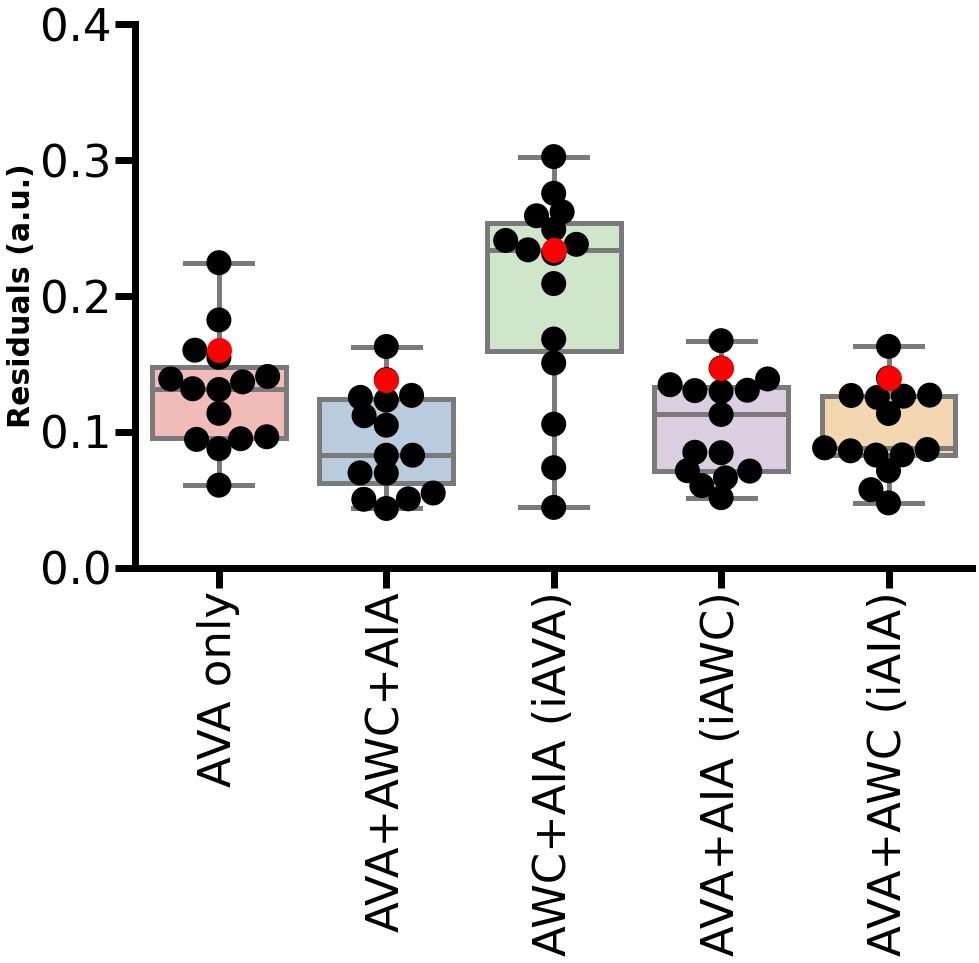

In [51]:
## Plotting Residuals for Comparison ##
# Just showing WT ignored models for simplicity 

# Import previously saved AVA-only residuals from previous modeling 
# (see 'Modeling Neuron Data - Single Neuron Convolution.ipynb' notebook)
WT_AVA_only_res = np.load('WT AVA Only Residuals.npy', allow_pickle=True).item()

data = np.array([ WT_AVA_only_res['Residual Both'], WT_sum_res, WT_iAVA_sum_res, WT_iAWC_sum_res, WT_iAIA_sum_res ])
labels = ['AVA only','AVA+AWC+AIA', 'AWC+AIA (iAVA)', 'AVA+AIA (iAWC)', 'AVA+AWC (iAIA)']

dF_sum = pd.DataFrame(data.T, columns=labels)
print(dF_sum)

colors = sns.color_palette("Pastel1")

fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 7
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
sns.boxplot(data=dF_sum,linewidth = 5, palette = colors)
sns.swarmplot(data=dF_sum, size=25, color = 'black')
sns.swarmplot(data=dF_sum.loc[[2]], size=25, color='red') ##
## Here I highlighted the specific trace (worm index #2) that I showed throughout the paper. 
# Note this actually duplicates the datapoint twice in the plot, so I just use this to highlight the datapoint.
plt.xticks(rotation=90)
ax.set_ylabel('Residuals (a.u.)', fontsize=30, weight='bold')
ax.set_ylim([0,0.4])
ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
#plt.savefig('Summation Residuals.svg')

     AVA amp   AWC amp   AIA amp
0   0.028480  0.026955 -0.009102
1   0.031652  0.009825 -0.001005
2   0.017727  0.012513 -0.004233
3   0.041261  0.003253 -0.022277
4   0.001679  0.013206  0.015846
5   0.011264 -0.009847  0.006879
6   0.024405 -0.017844  0.015423
7  -0.005355  0.003110  0.011280
8   0.014550  0.012158 -0.010309
9   0.014636  0.016810 -0.000138
10  0.029325  0.011056  0.001188
11  0.027174  0.005279  0.000500
12  0.024301  0.004150 -0.005383
13  0.022523  0.005879 -0.002196
14  0.028631  0.003012 -0.011263


"\n\ndata = np.array([ long_data, short_data+([np.nan]*diff)])\n\nlet's say long_data is 15 worms, short_data is 12 worms, so pad nans with nans*3 to even out length\n\n"

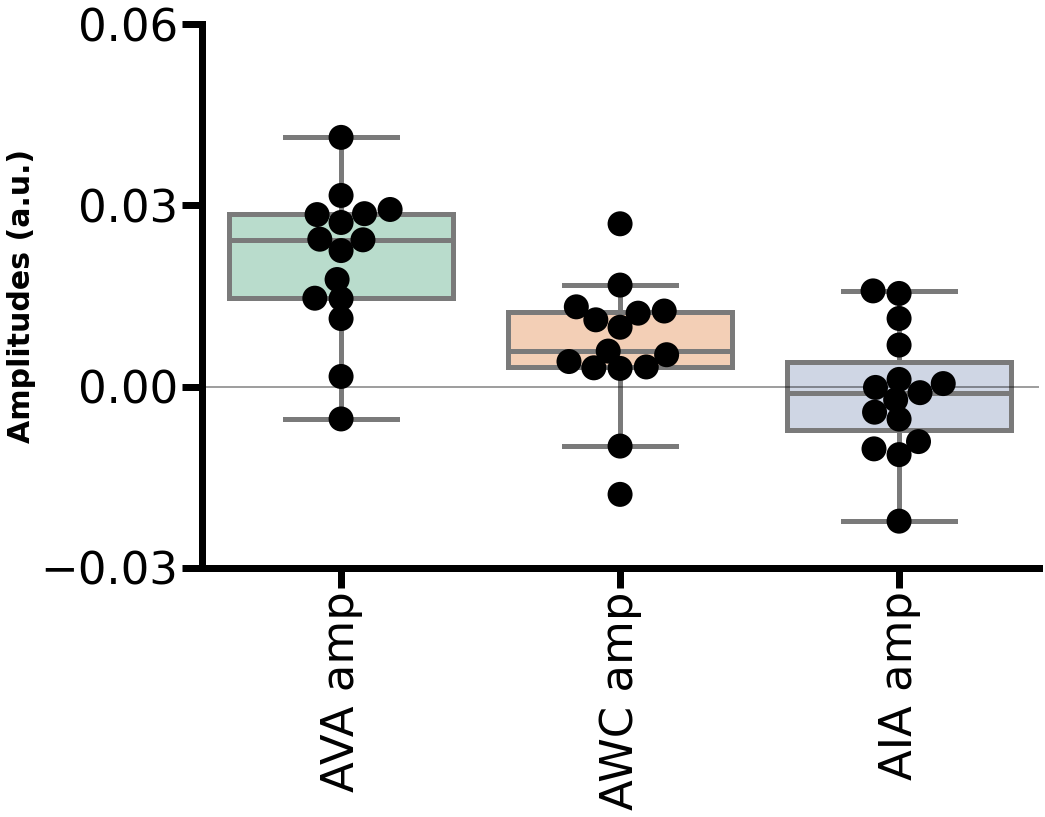

In [94]:
## Plotting Amplitudes for Comparison ##
# Just showing WT models for simplicity, feel free to compare any and all combos (WT/full, ignored, silenced)
# Note that if you want to plot WT vs non-WT data together (silenced), they have different n's. The way for me to 
# plot them is commented out at bottom - I pad the shorter datasets with nans (nans don't get plotted).

data = np.array([WT_sum_AVA_amp, WT_sum_AWC_amp, WT_sum_AIA_amp])
labels = ['AVA amp', 'AWC amp', 'AIA amp']

dF_amps = pd.DataFrame(data.T, columns=labels)
print(dF_amps)

colors = sns.color_palette("Pastel2")

fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 7
sns.boxplot(data=dF_amps,linewidth = 5, palette = colors)
sns.swarmplot(data=dF_amps, size=25, color = 'black')
#sns.swarmplot(data=dF_amps.loc[[2]], size=25, color='red') 
plt.axhline(y=0, color='black', alpha=0.5)
plt.xticks(rotation=90)
ax.set_ylim([-0.03,0.06])
plt.yticks(np.arange(-0.03,0.09, step=0.03))
ax.set_ylabel('Amplitudes (a.u.)', fontsize=30, weight='bold')
ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
# How to plot uneven datasets (ie WT vs silenced worms):
"""

data = np.array([ long_data, short_data+([np.nan]*diff)])

let's say long_data is 15 worms, short_data is 12 worms, so pad nans with nans*3 to even out length

"""

In [57]:
## Statistics ##

from scipy.stats import mannwhitneyu 
# mann-whitney U is for unpaired samples (between WT and HisCl (silenced) exps)

from scipy.stats import wilcoxon 
# wilcoxon is for paired samples (across all WT models) -- only works with same-length datasets for this reason

def Stats_model(choice, sample1, sample2, name):
    
    if choice == 'wilcoxon':
        new_array = []
        for i in range(len(sample1)):
            diff = sample1[i] - sample2[i] # *
            rounded = np.round(diff, decimals=2) # * this was suggested by scipy.wilcoxon documentation
            new_array.append(rounded)
        w = wilcoxon(new_array, y=None)
        p = w.pvalue
    if choice == 'mannwhitney':   
        U, p = mannwhitneyu(sample1, sample2)
    
    if p < 0.001:
        print(name, '***', p)
    elif p < 0.01:
        print(name, '**', p)
    elif p < 0.05:
        print(name, '*', p)
    elif p > 0.05:
        print(name, 'NS', p)
        
    return p

# Will just display residuals between WT full and WT ignored models for simplicity #

p1 = Stats_model('wilcoxon', WT_AVA_only_res['Residual Both'], WT_sum_res, 'AVA-only vs AVA+AWC+AIA')
p2 = Stats_model('wilcoxon', WT_AVA_only_res['Residual Both'], WT_iAVA_sum_res, 'AVA-only vs AWC+AIA (iAVA)')
p3 = Stats_model('wilcoxon', WT_AVA_only_res['Residual Both'], WT_iAWC_sum_res, 'AVA-only vs AVA+AIA (iAWC)')
p4 = Stats_model('wilcoxon', WT_AVA_only_res['Residual Both'], WT_iAIA_sum_res, 'AVA-only vs AWC+AIA (iAIA)')
p5 = Stats_model('wilcoxon', WT_sum_res, WT_iAVA_sum_res, 'AVA+AWC+AIA vs AWC+AIA (iAVA)')
p6 = Stats_model('wilcoxon', WT_sum_res, WT_iAWC_sum_res, 'AVA+AWC+AIA vs AVA+AIA (iAWC)')
p7 = Stats_model('wilcoxon', WT_sum_res, WT_iAIA_sum_res, 'AVA+AWC+AIA vs AWC+AIA (iAIA)')
p8 = Stats_model('wilcoxon', WT_iAVA_sum_res, WT_iAWC_sum_res, 'AWC+AIA (iAVA) vs AVA+AIA (iAWC)')
p9 = Stats_model('wilcoxon', WT_iAVA_sum_res, WT_iAIA_sum_res, 'AWC+AIA (iAVA) vs AWC+AIA (iAIA)')
p10 = Stats_model('wilcoxon', WT_iAWC_sum_res, WT_iAIA_sum_res, 'AVA+AIA (iAWC) vs AWC+AIA (iAIA)')

AVA-only vs AVA+AWC+AIA ** 0.001410512473214279
AVA-only vs AWC+AIA (iAVA) ** 0.00537109375
AVA-only vs AVA+AIA (iAWC) ** 0.007420961287866498
AVA-only vs AWC+AIA (iAIA) ** 0.0030123054507454855
AVA+AWC+AIA vs AWC+AIA (iAVA) ** 0.0014492334559826675
AVA+AWC+AIA vs AVA+AIA (iAWC) * 0.010613156038105713
AVA+AWC+AIA vs AWC+AIA (iAIA) NS 0.06559969214707187
AWC+AIA (iAVA) vs AVA+AIA (iAWC) ** 0.0013554710595550011
AWC+AIA (iAVA) vs AWC+AIA (iAIA) ** 0.0012046482182742305
AVA+AIA (iAWC) vs AWC+AIA (iAIA) NS 0.7980737221573263


/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [58]:
## Holm-Bonferroni Correction of Residuals ##
# This is a multiple comparison test between all p-values to correct for any potential statistical errors and
# false significance. This returns new, adjusted p-values based on the provided group of tests (ie all the WT exps)
# Bonferroni is a more stringent test, and Holm is a variation that is more tailored to your data.
# Because of this, you want to group your comparisons in a meaningful way (ie all ignored together to see which 
# ignored scenario is statistically different, or compare all AWC-silenced/ignored scenarios, or compare all WT
# scenarios, etc.)
# In the paper, all comparisons were usually done within whatever plot was shown. 

# Here I have just grouped them all together. 

import statsmodels.stats.multitest as multi

WT_pvals = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10]
hb1 = multi.multipletests(WT_pvals, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)
# Displays True/False statements of significance, followed by new corrected p values.
print(hb1)

for p in hb1[1]: # just to show significance of adjusted p-values
    if p < 0.001:
        print('***', p)
    elif p < 0.01:
        print('**', p)
    elif p < 0.05:
        print('*', p)
    elif p > 0.05:
        print('NS', p)

(array([ True,  True,  True,  True,  True,  True, False,  True,  True,
       False]), array([0.01219924, 0.02685547, 0.02968385, 0.01807383, 0.01219924,
       0.03183947, 0.13119938, 0.01219924, 0.01204648, 0.79807372]), 0.005116196891823743, 0.005)
* 0.01219923953599501
* 0.02685546875
* 0.029683845151465993
* 0.018073832704472912
* 0.01219923953599501
* 0.03183946811431714
NS 0.13119938429414374
* 0.01219923953599501
* 0.012046482182742305
NS 0.7980737221573263


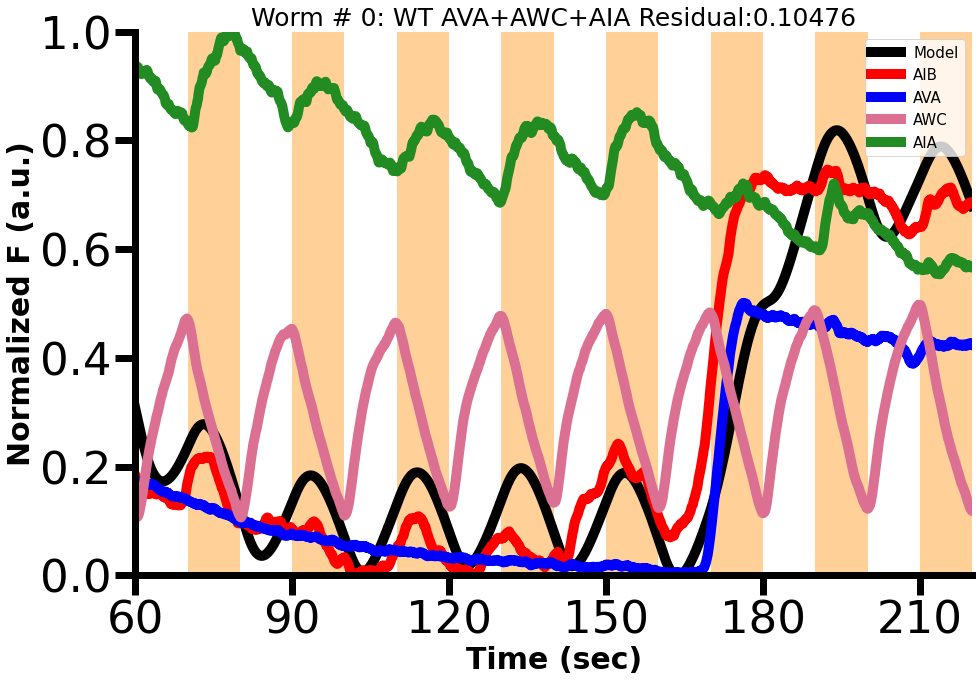

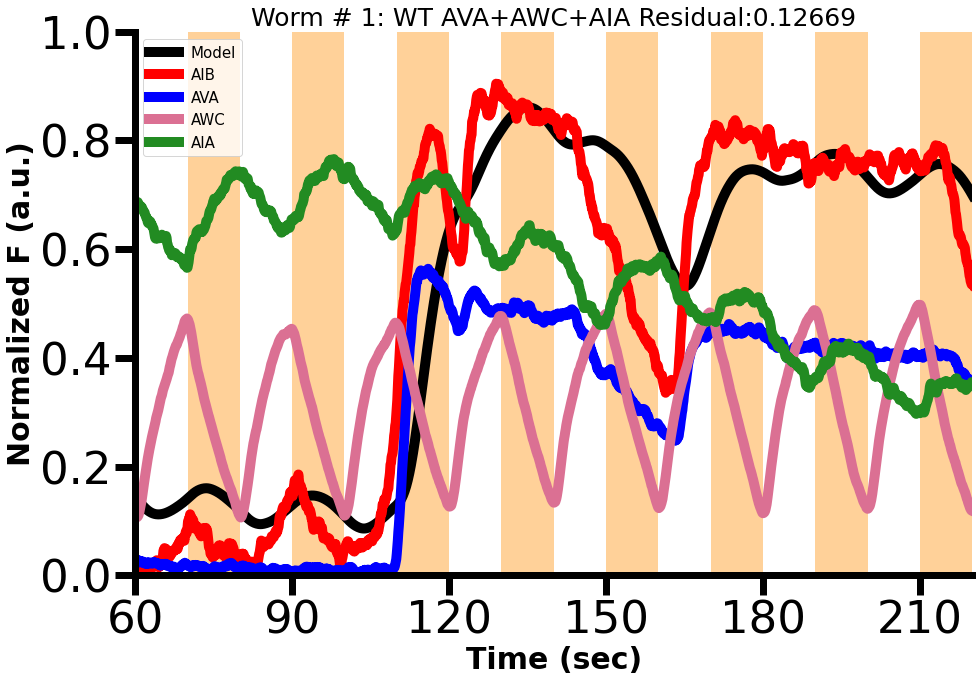

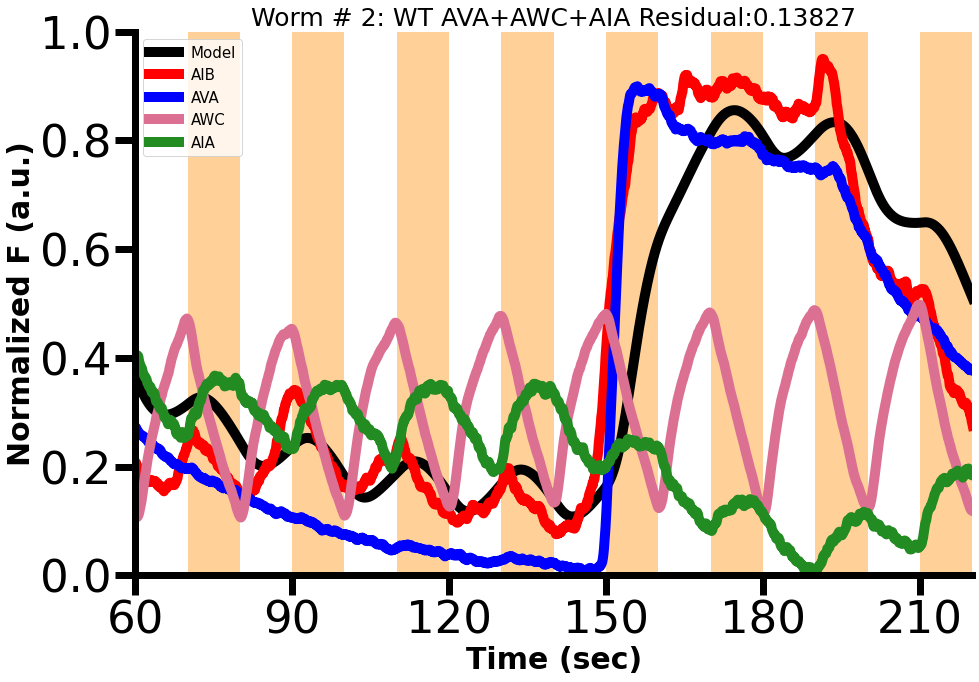

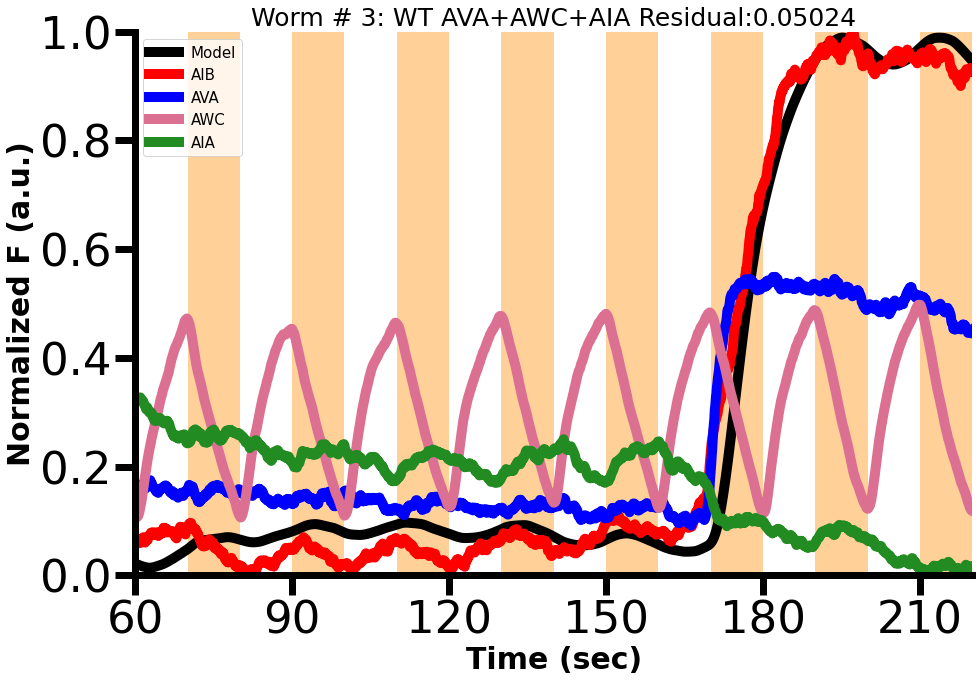

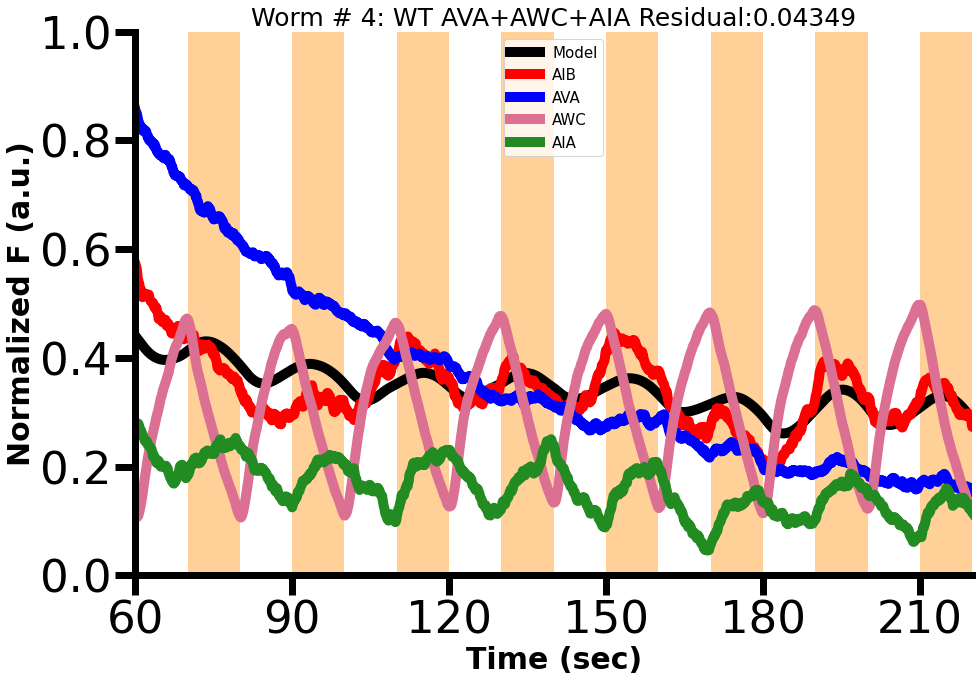

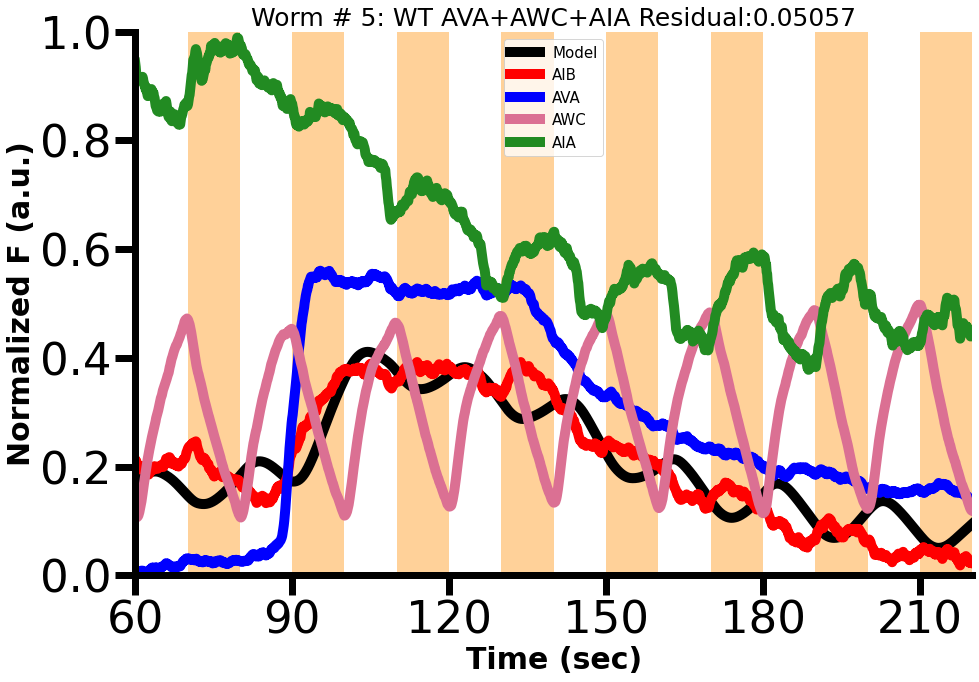

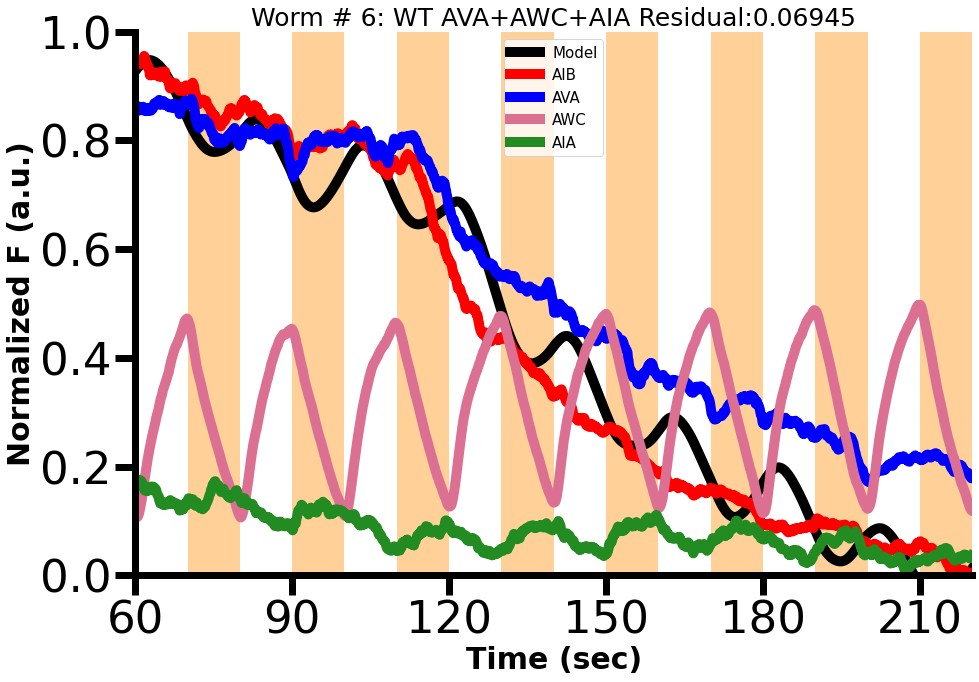

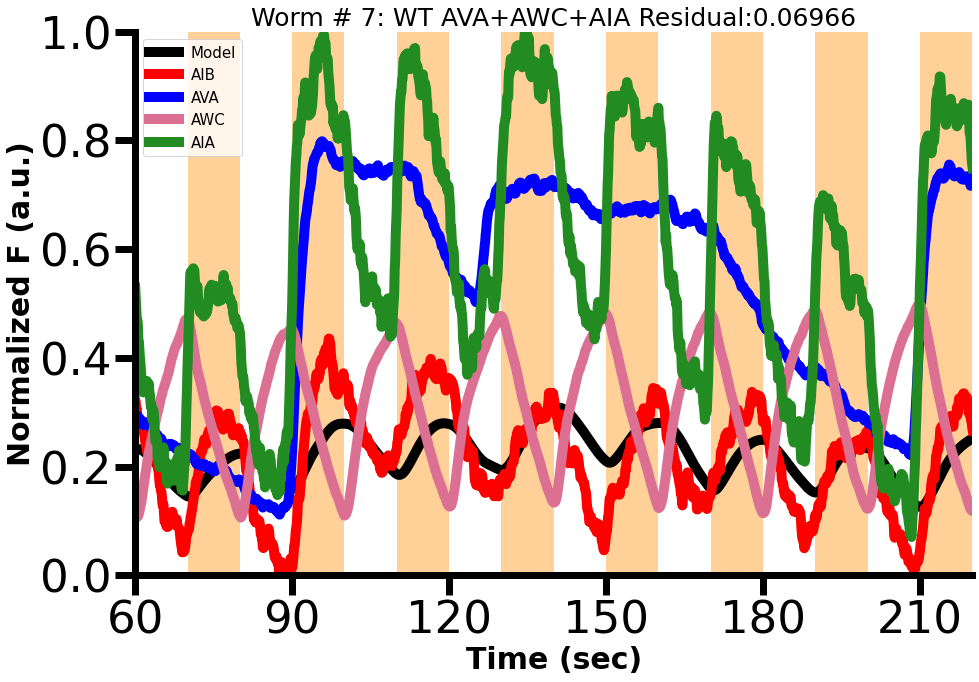

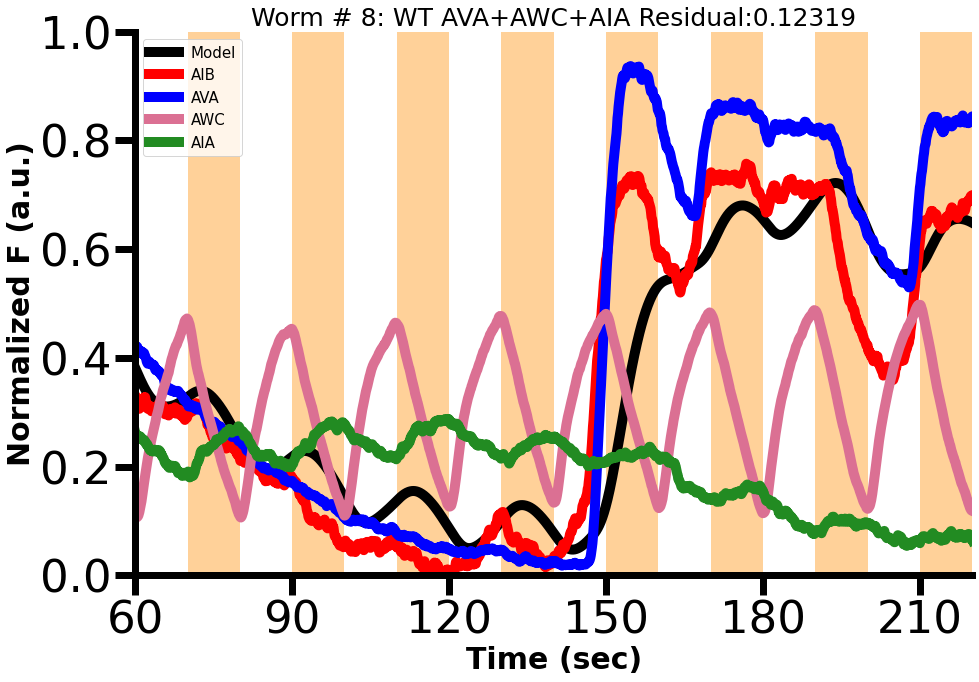

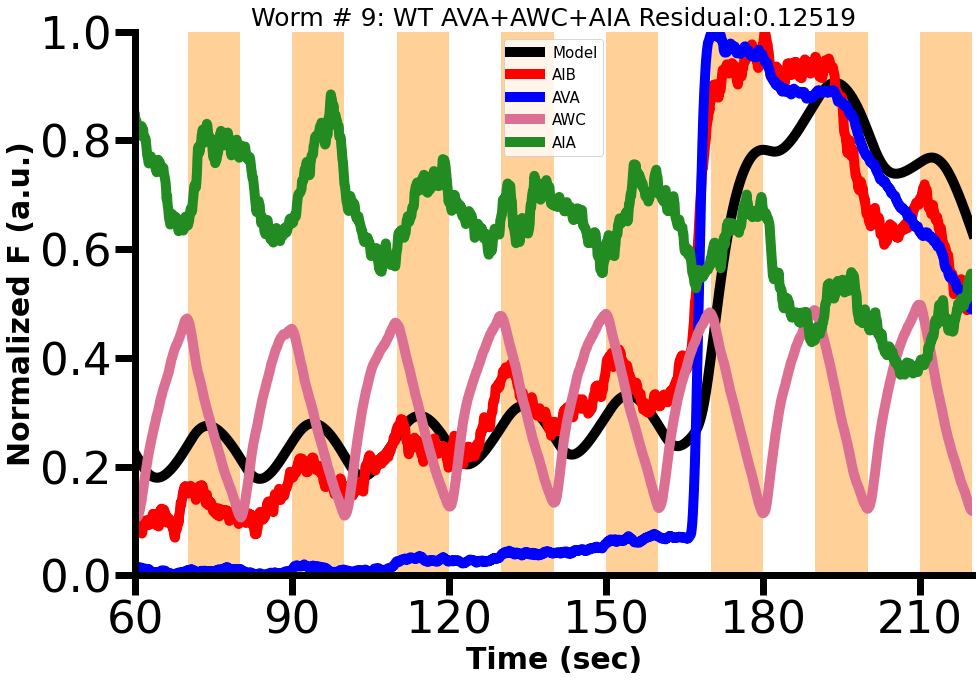

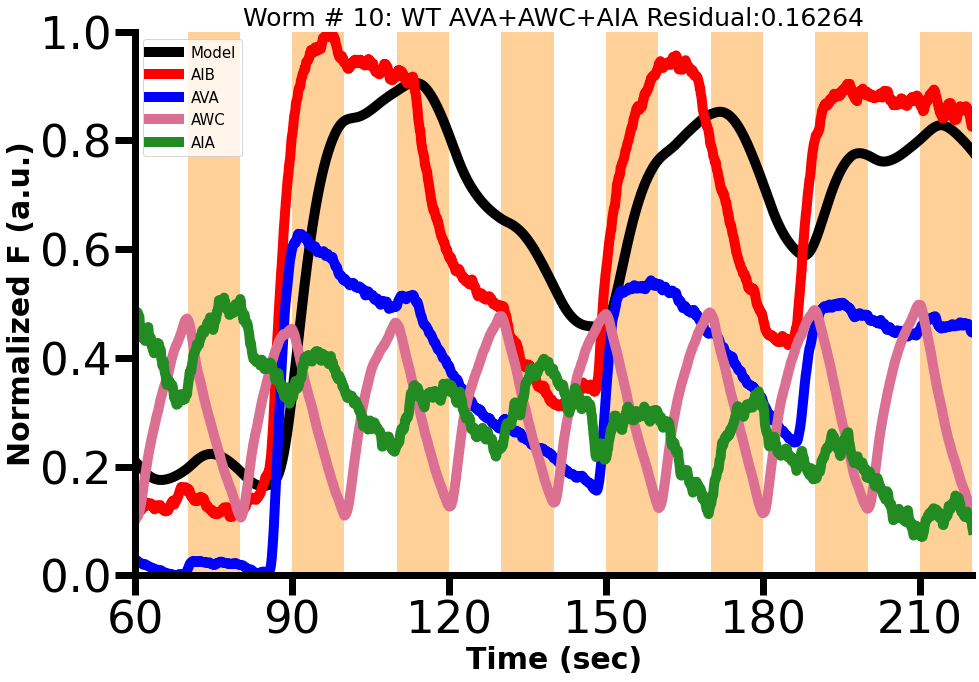

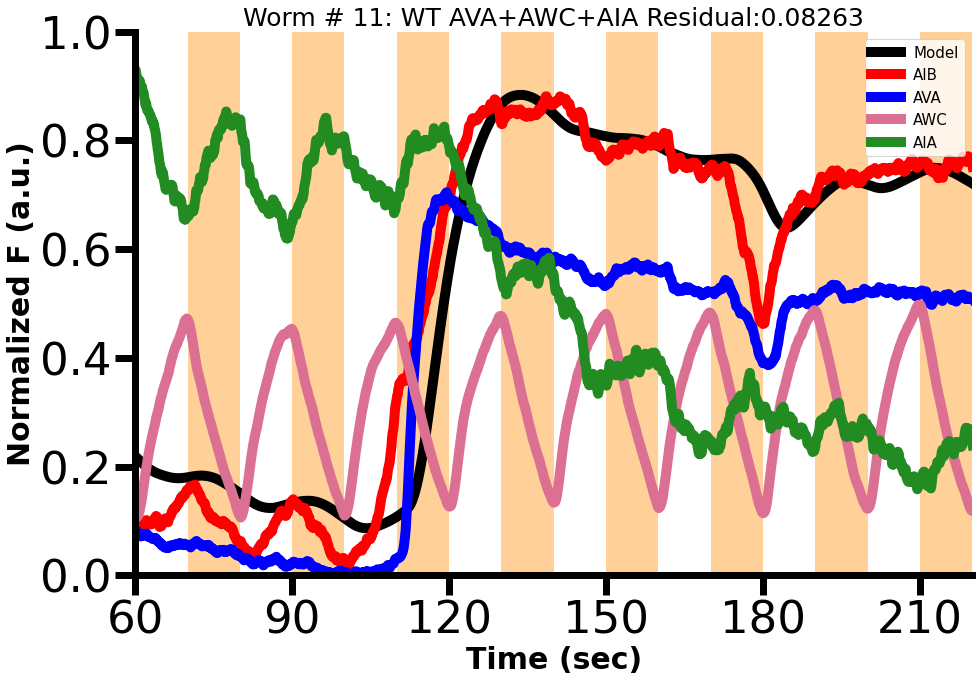

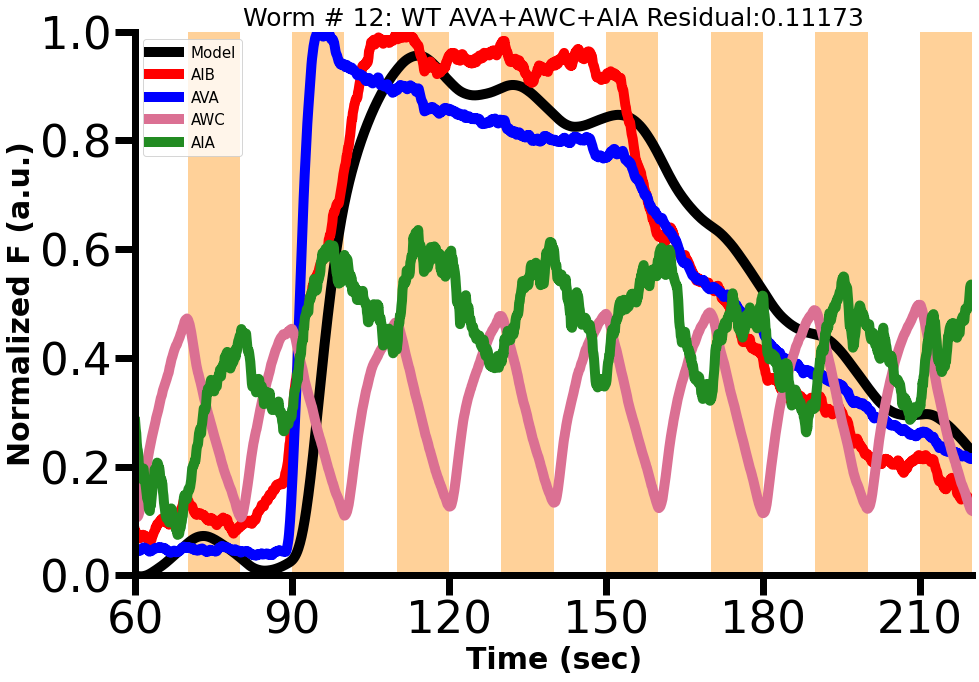

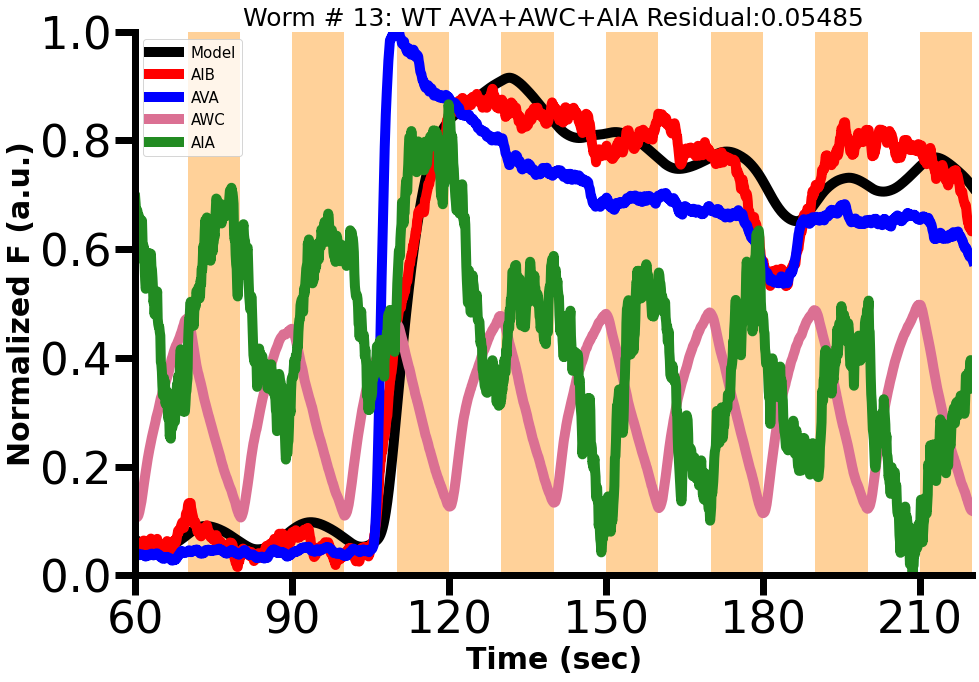

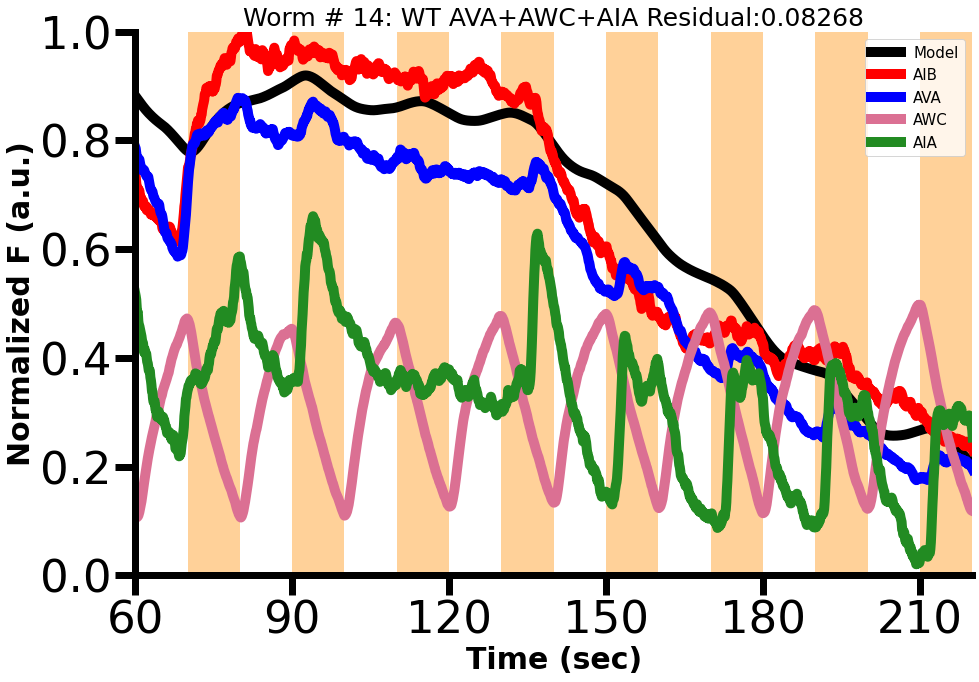

In [85]:
## - Plotting Traces and Model - ##
# Will just show odor+red light experiments as examples. 
# Note that when plotting normalized neuron traces with model, that the modeling process cuts off the first
# 249 frames, so to align neuron traces with model trace, need to cut off neuron trace AIB[249:]


# Easier to change between worms/exps this way
worm_num = WT_worm_num # 15 for WT, 14 for strHis, 12 for insHis, 20 for nmrHis
residual_plot = WT_sum_res
model_plot = WT_sum_models
aib_plot = WT_AIB_both 
ava_plot = WT_AVA_both
awc_plot = WT_AWC_both_avg
aia_plot = WT_AIA_both
title_name = 'WT AVA+AWC+AIA'

# Which plots used for figures (worm index #):
# WT (full and ignored) = 2
# nmrHis = 18 
# strHis = 2
# insHis = 11

# This is to plot in seconds (10 fps). Sort of complicated, but normalization cuts off 350 frames in beginning, 
# and convolution process cuts off an additional 249 frames (time window - 1) in beginning, totaling 599 frames. 
# I rounded it up to 600, and added the extra 1 frame shift to the end for simplicity, because I cut off the
# last 90 frames. There is originally a total of 2300 frames, but the smoothing process (5 frames x2) cuts off 10,
# so new length is 2290 (plus the 1 extra frame shift I added to help round the beginning). Thus, 600,2291.
# This is all just for publication and for transparency of where the ACTUAL time starts in my raw traces.
# Feel free to change to time that makes more sense lol :) 
timeplot = []
for t in range(600,2291): 
    temp = t/10
    timeplot.append(temp)

for i in range(worm_num):
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w') 
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 7
    ax.set_title('Worm # '+str(i) + ': '+ title_name + ' Residual:'+str(residual_plot[i])[:7], fontsize=25)
    ax.plot(timeplot, model_plot[i], color = 'black', linewidth=10, label='Model')
    ax.plot(timeplot, aib_plot[i][249:], color = 'red', linewidth=10, alpha=1, label='AIB') 
    ax.plot(timeplot, ava_plot[i][249:], color = 'blue', linewidth=10, alpha=1, label='AVA') 
    ax.plot(timeplot, awc_plot[i][249:], color = 'palevioletred', linewidth=10, alpha=1, label='AWC') 
    ax.plot(timeplot, aia_plot[i][249:], color = 'forestgreen', linewidth=10, alpha=1, label='AIA') 
    ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
    ax.set_ylabel('Normalized F (a.u.)', fontsize=30, weight='bold')
    ax.set_xlabel('Time (sec)', fontsize=30, weight='bold')
    ax.set_ylim([0,1])
    ax.set_xlim([60,220])
    ax.legend(loc='best', fontsize=15)
    plt.xticks(np.arange(60, 220, step=30))
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        
    # If you want to color-code stimuli delivery times, use code below or comment out if don't want
    
    for j in range(0,22): #0,16
        if j % 2 != 0:
            start = j*10
            stop = (j*10)+10
            ax.axvspan(start, stop, facecolor='darkorange', alpha=0.4) 
            ## odor_color = yellow 
            ## redlight_color = crimson 
            ## both_color = darkorange
            
    #plt.savefig(title_name + '.svg')

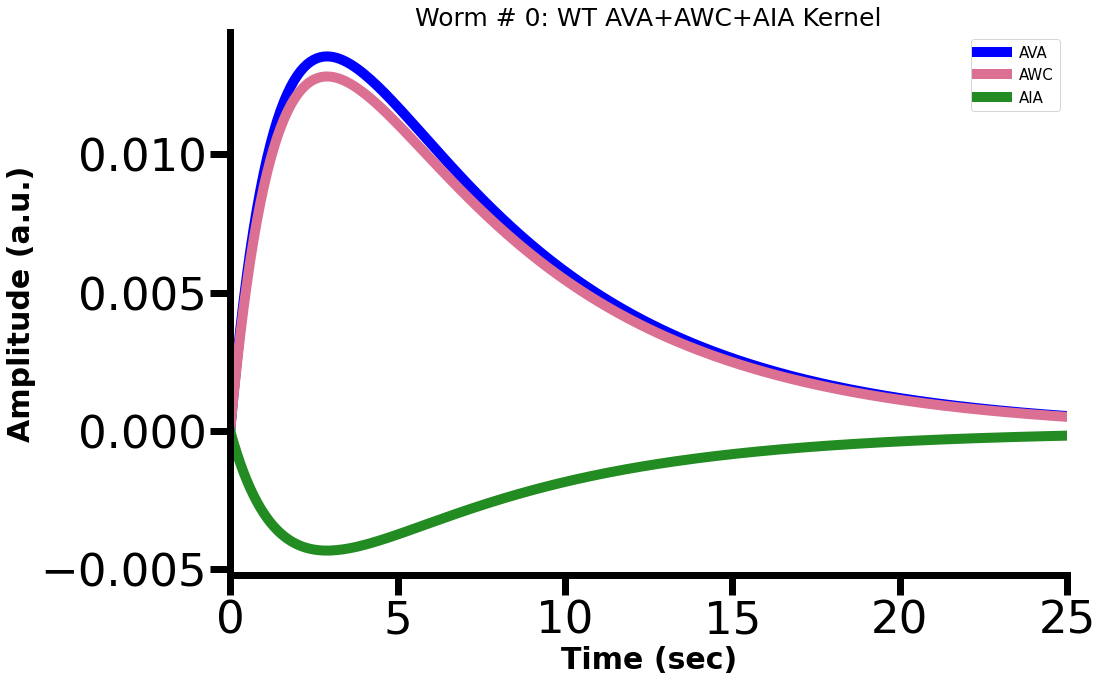

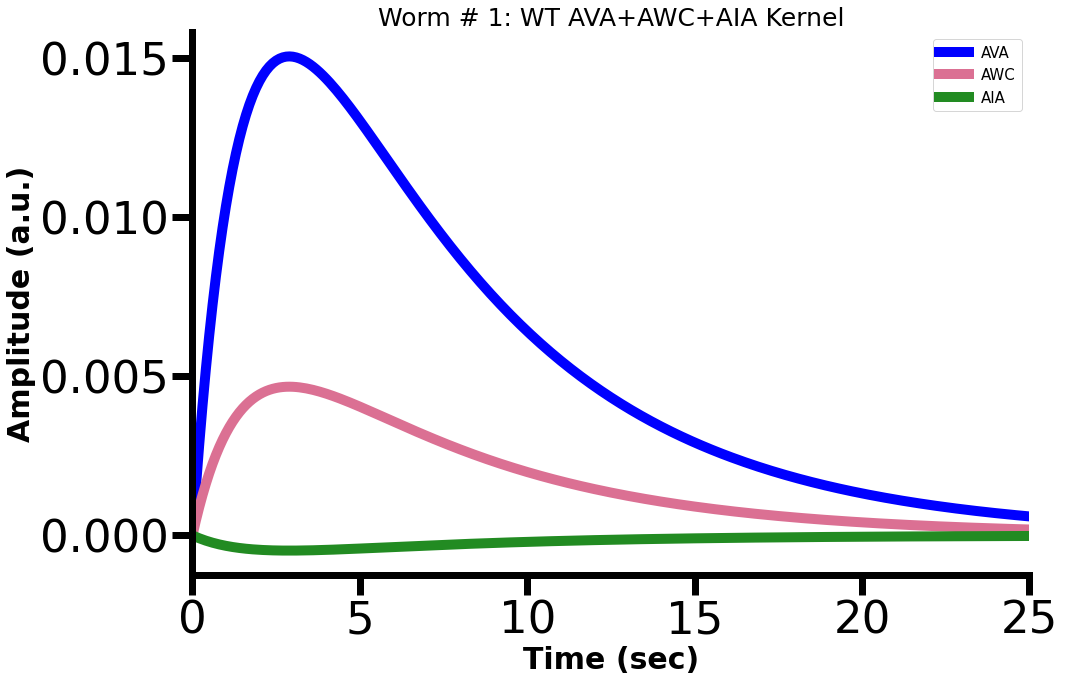

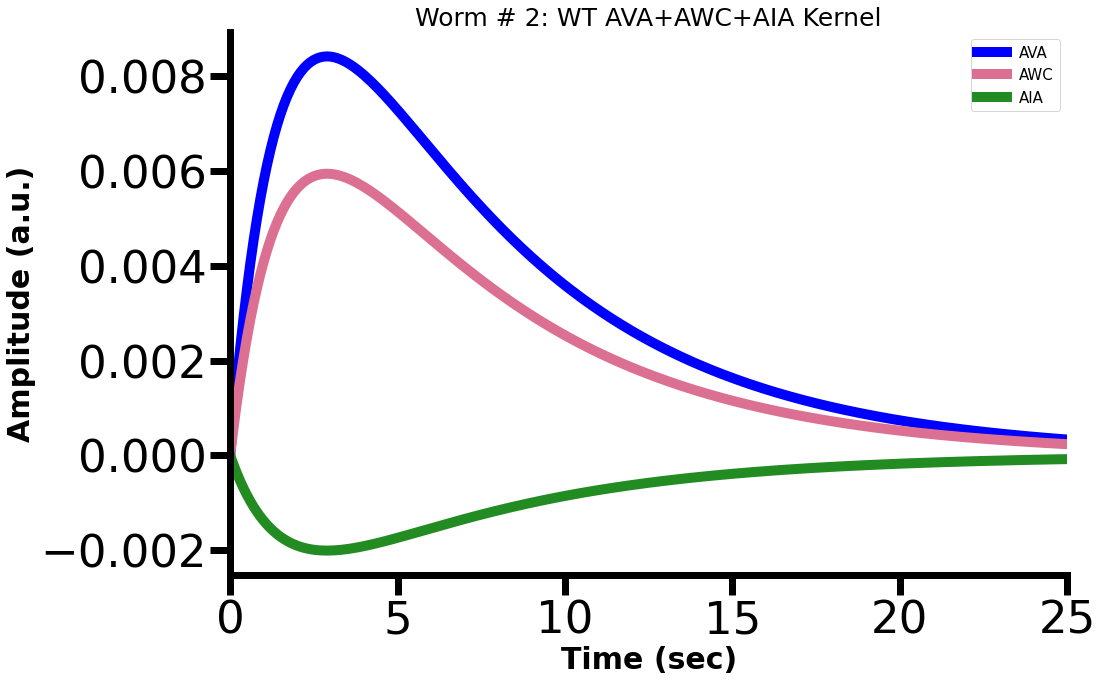

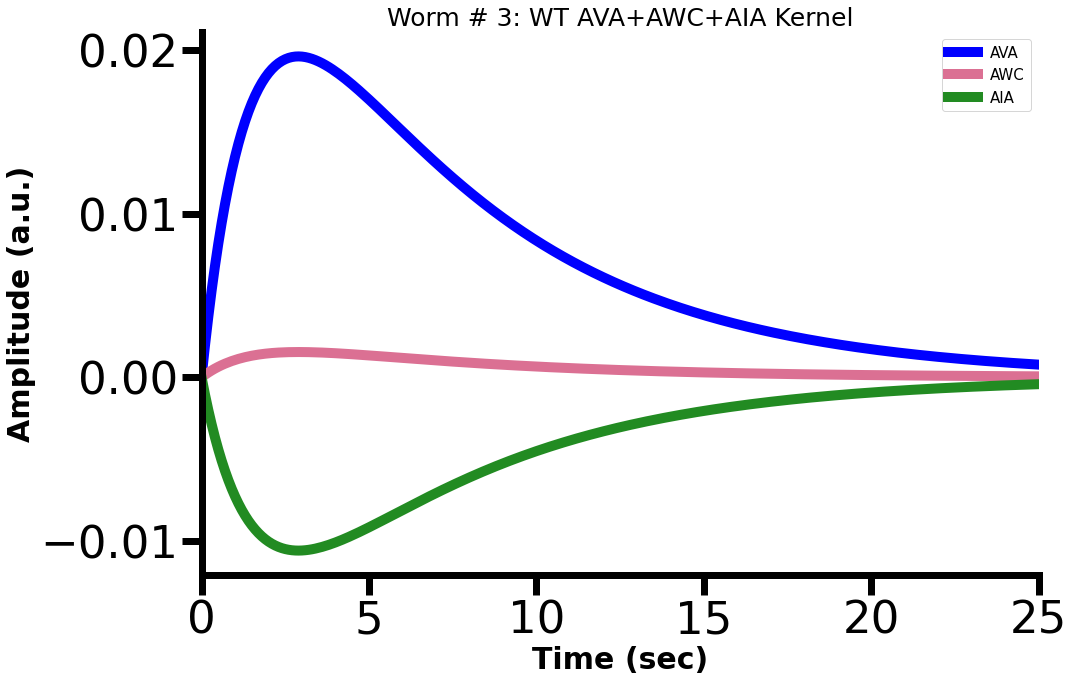

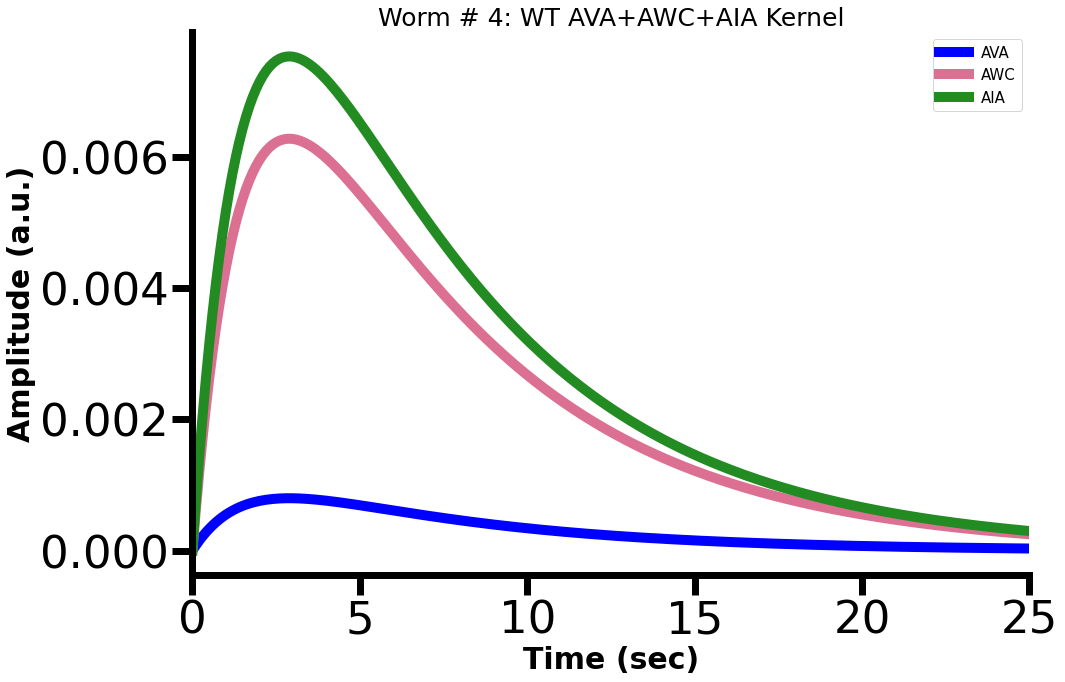

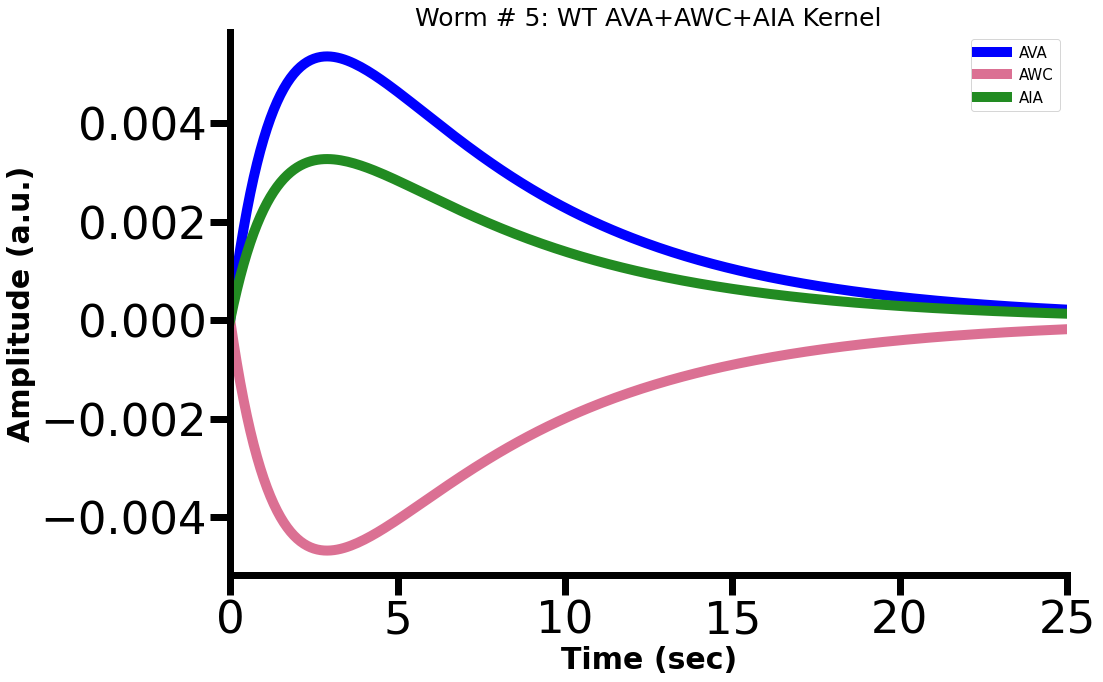

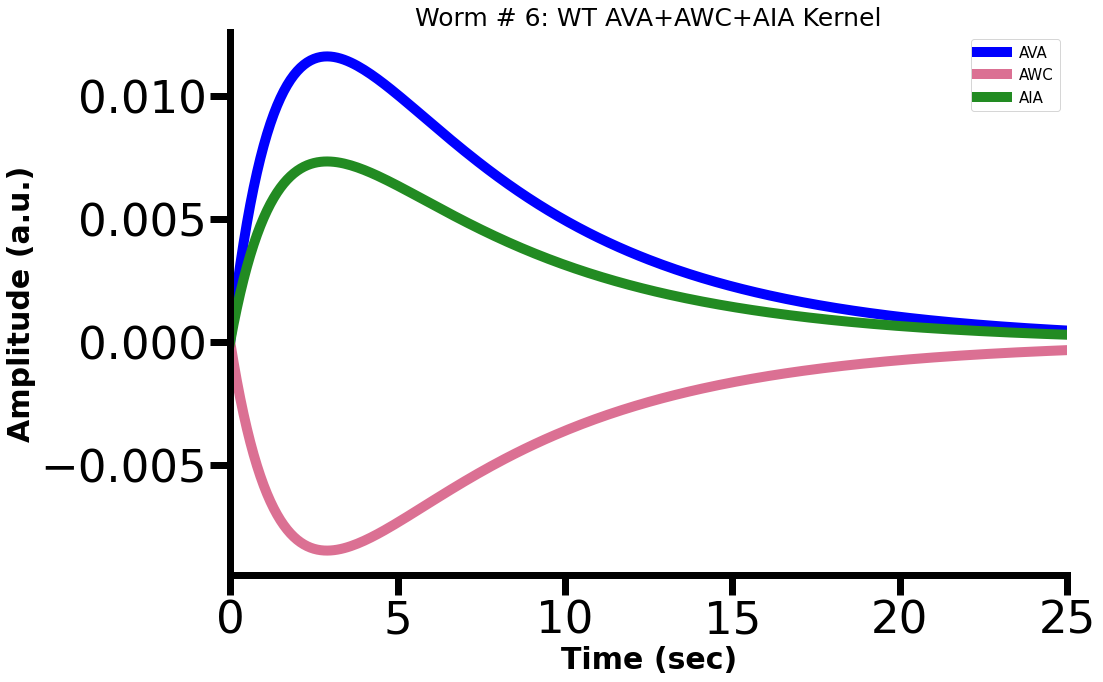

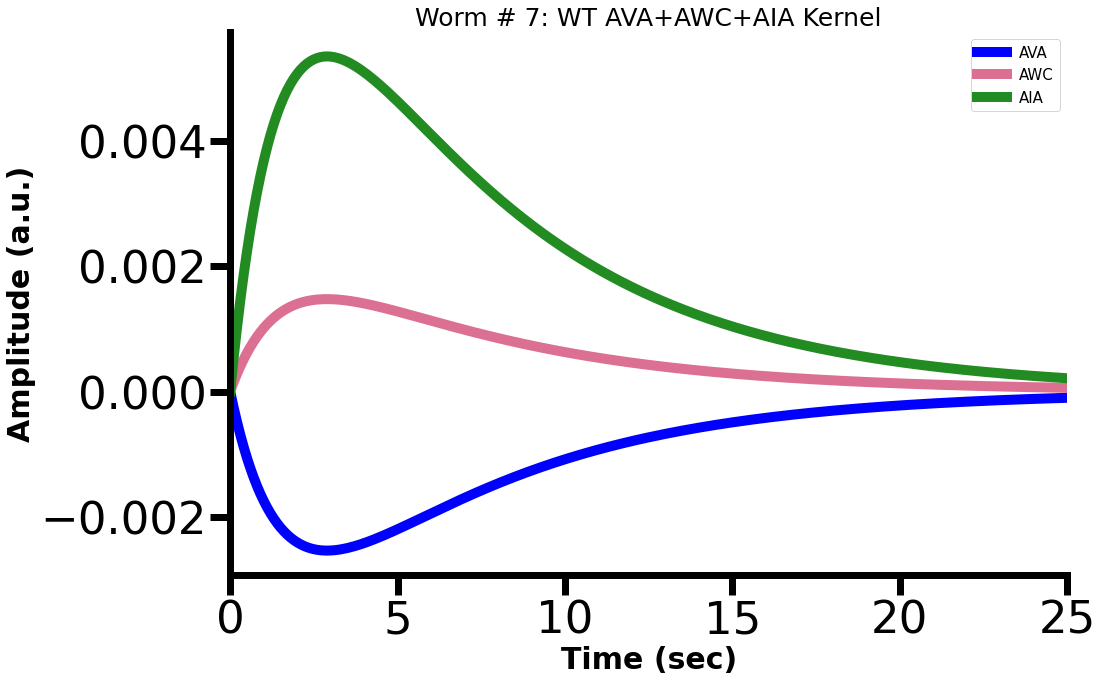

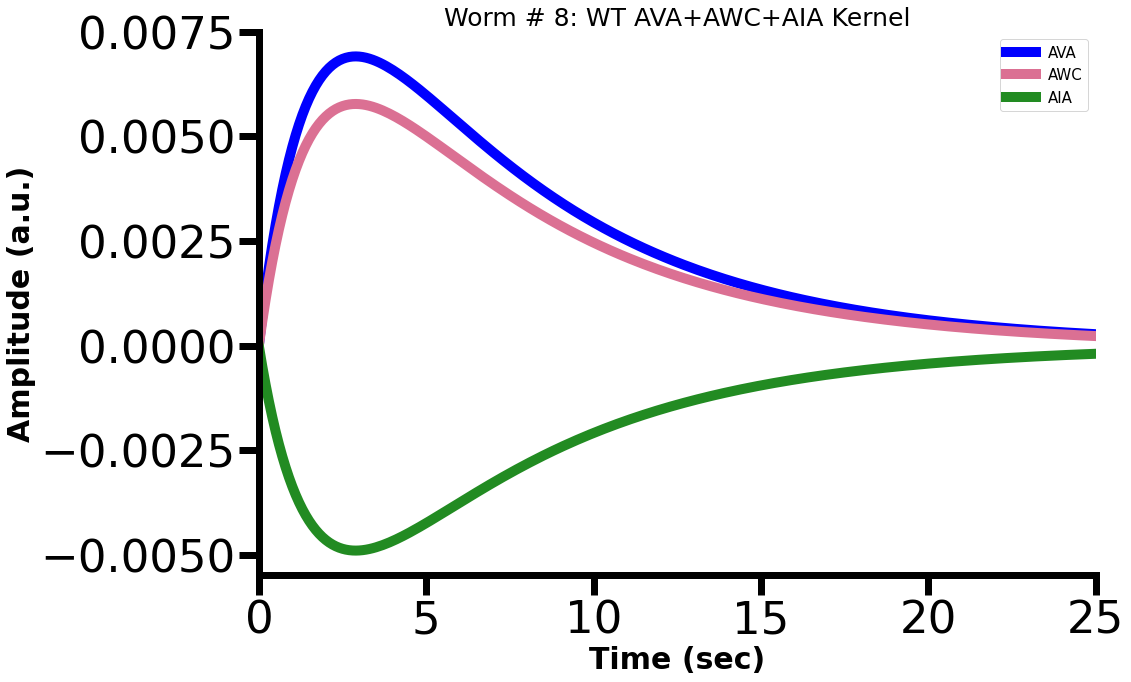

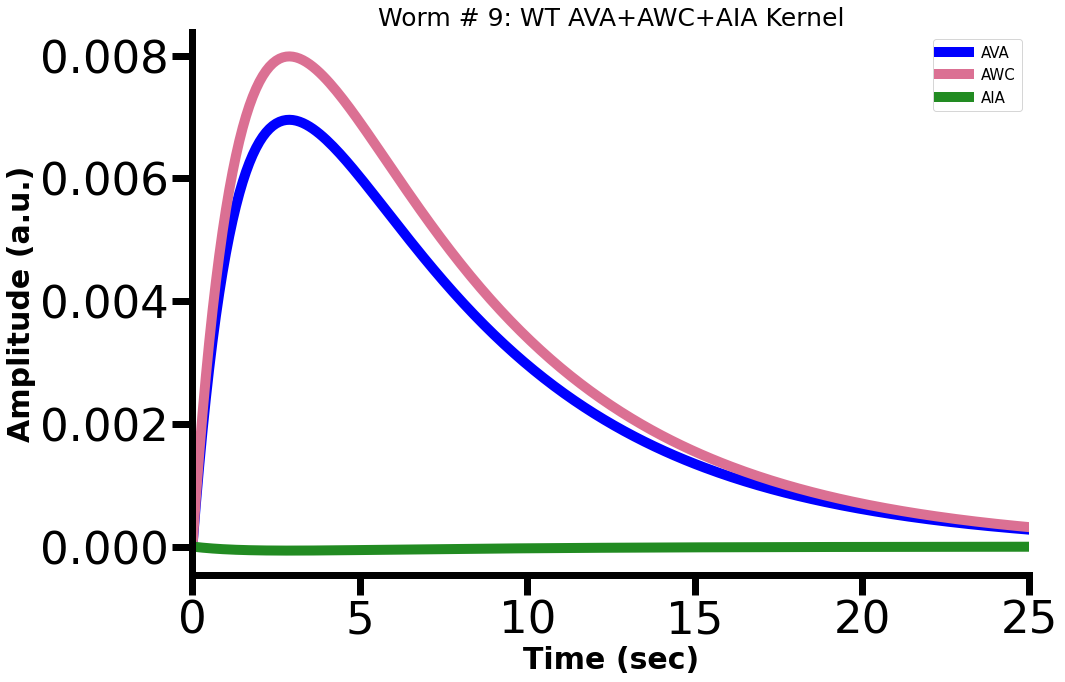

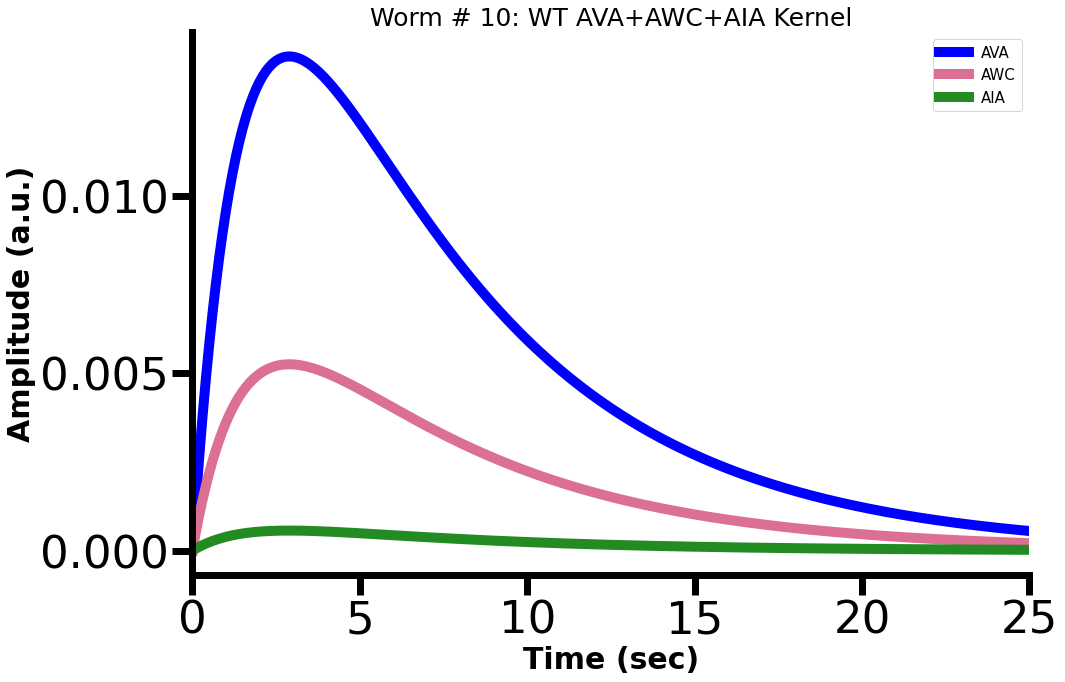

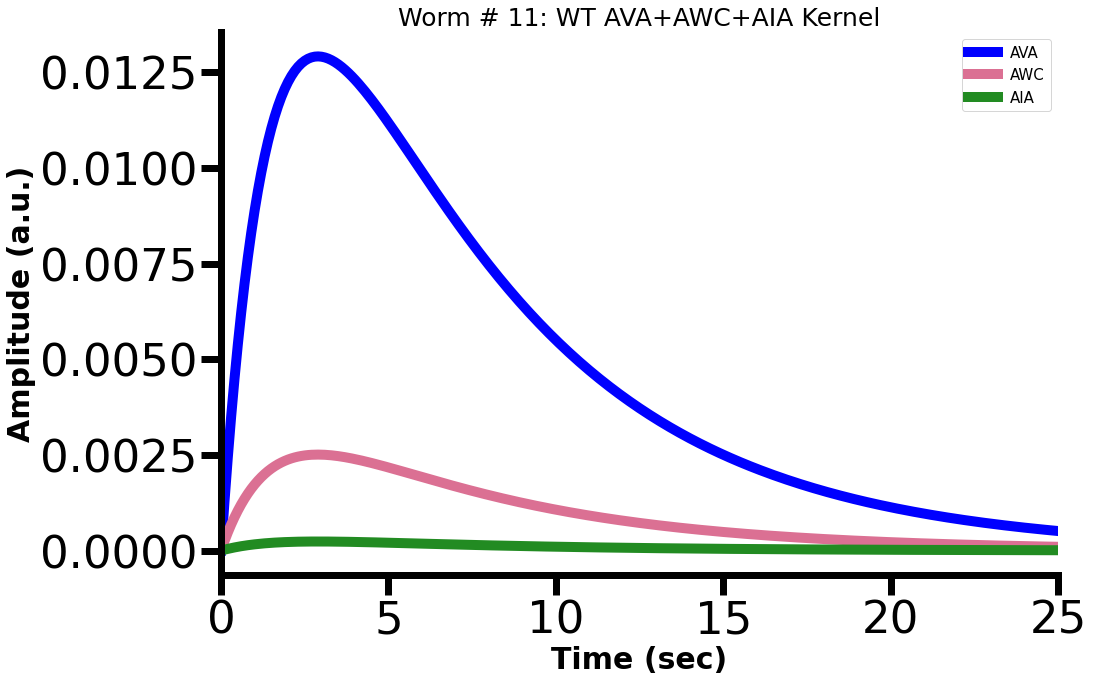

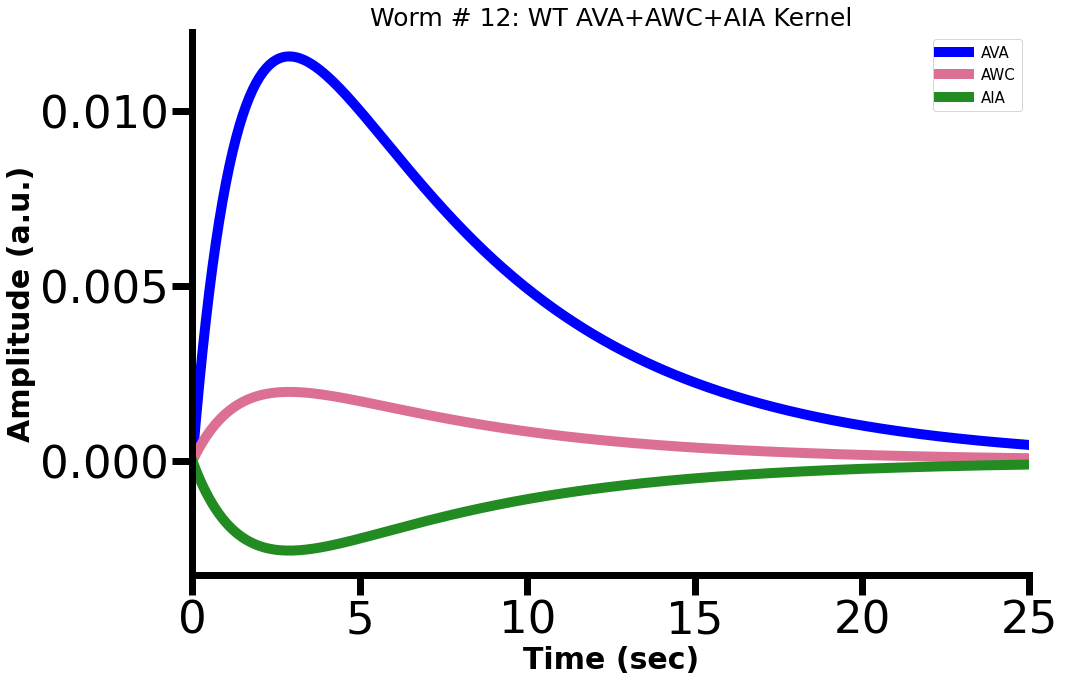

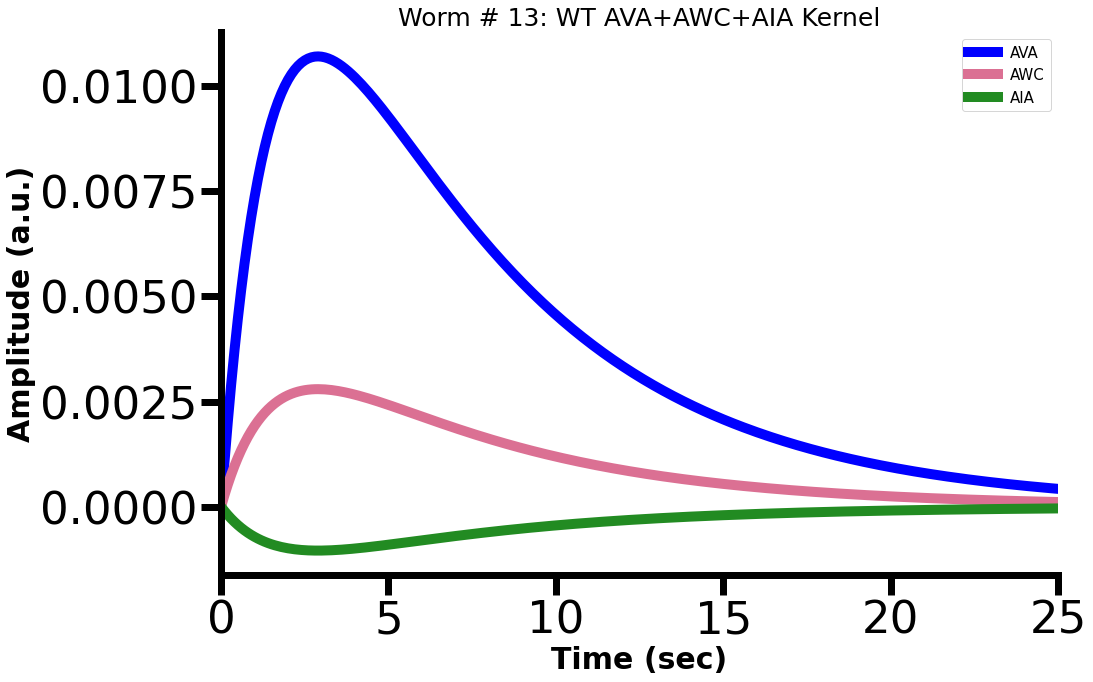

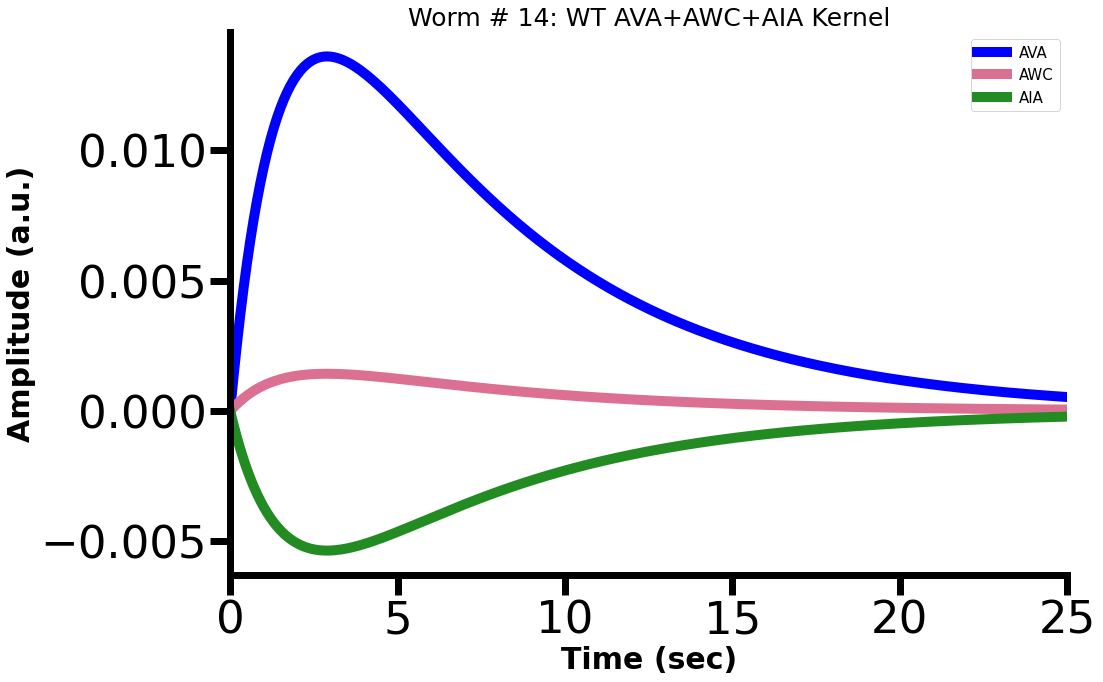

In [69]:
## - Plotting Kernels - ##
# Will show just odor+red light exps for simplicity (corresponds to above model plots)

t = np.arange(0, 250) #length of kernel window

worm_num = WT_worm_num
title_name = 'WT AVA+AWC+AIA'
ava_amps = WT_sum_AVA_amp
awc_amps = WT_sum_AWC_amp
aia_amps = WT_sum_AIA_amp
alpha1 = WT_AVA_only_params['Alpha1 Both']
# this is the median value, don't need to loop (below)
alpha2 = WT_AVA_only_params['Alpha2 Both']
# this is the median value, don't need to loop (below)

# Kernel time window is 250 frames (25 seconds) -- much more straightforward than above lol 
timeplot = []
for p in range(250):
    temp = p/10
    timeplot.append(temp)

for i in range(worm_num):
    kernel_ava = ava_amps[i] * (np.exp(-alpha1*t) - np.exp(-alpha2*t)) # just loop through amps
    kernel_awc = awc_amps[i] * (np.exp(-alpha1*t) - np.exp(-alpha2*t))
    kernel_aia = aia_amps[i] * (np.exp(-alpha1*t) - np.exp(-alpha2*t))
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 7
    ax.set_title('Worm # '+str(i) + ': '+ title_name + ' Kernel', fontsize=25)
    ax.plot(timeplot, kernel_ava, color='blue', linewidth=10, alpha=1, label = 'AVA')
    ax.plot(timeplot, kernel_awc, color='palevioletred', linewidth=10, alpha=1, label = 'AWC')
    ax.plot(timeplot, kernel_aia, color='forestgreen', linewidth=10, alpha=1, label = 'AIA')
    ax.set_ylabel('Amplitude (a.u.)', fontsize=30, weight='bold')
    ax.set_xlabel('Time (sec)', fontsize=30, weight='bold')
    ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
    ax.set_xlim([0,25])
    ax.legend(loc='best', fontsize=15)
    #ax.set_ylim([-0.005,0.015])
    #plt.yticks(np.arange(0, 0.02, step=0.005))
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    #plt.savefig(title_name + '.svg')

